In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from imgaug import augmenters as iaa


In [2]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)


In [7]:
data = XO('../all/*')
data
print(os.getcwd())

c:\Users\user\Documents\DL\Learn\UI\code


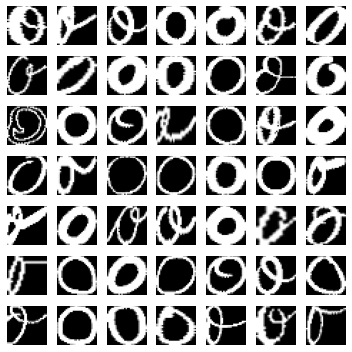

In [8]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [9]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [10]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [12]:
trn_dl = DataLoader(XO('../all/*'), batch_size=32, drop_last=True)

In [13]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [14]:
model, loss_fn, optimizer = get_model()

In [15]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))



Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            640
├─MaxPool2d: 1-2                         --
├─ReLU: 1-3                              --
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─ReLU: 1-6                              --
├─Flatten: 1-7                           --
├─Linear: 1-8                            819,456
├─ReLU: 1-9                              --
├─Linear: 1-10                           257
├─Sigmoid: 1-11                          --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0

In [16]:
for epoch in range(5):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        # print(batch_loss)

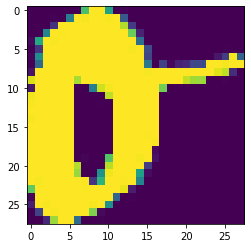

In [17]:
im, c = trn_dl.dataset[5]
plt.imshow(im[0].cpu())
plt.show()

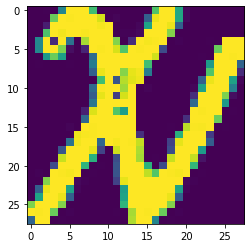

In [18]:
i2, x = trn_dl.dataset[2010]
plt.imshow(i2[0].cpu())
plt.show()

In [20]:
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

In [21]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer[0].weight[0]

tensor([[[ 0.1057,  0.3147,  0.0877],
         [ 0.1269, -0.3091, -0.1973],
         [ 0.1011, -0.0254,  0.0451]]], grad_fn=<SelectBackward0>)

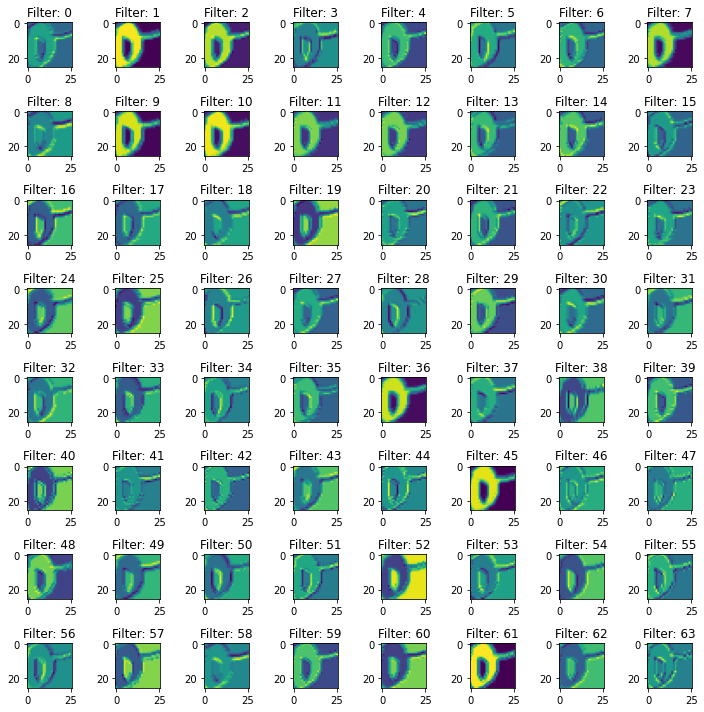

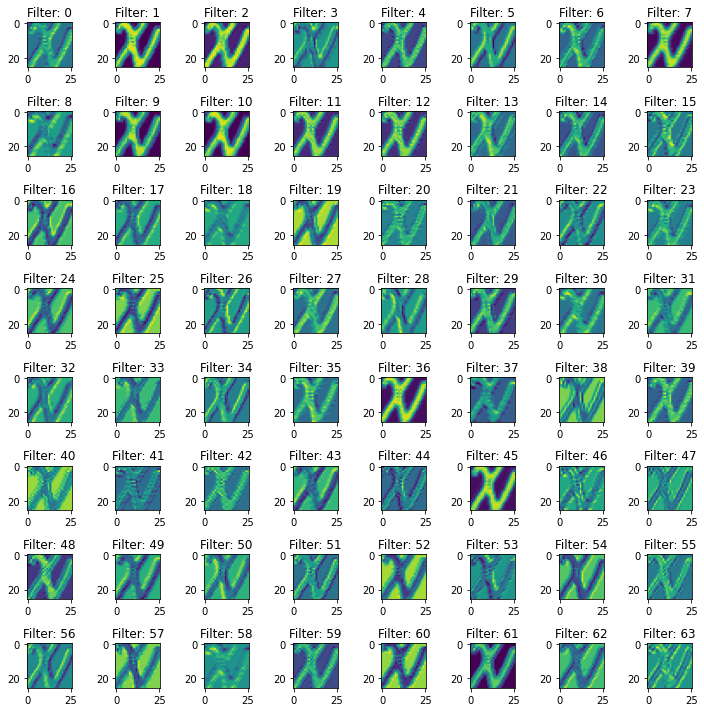

In [22]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(i2[None])[0].detach()

n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()


In [23]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=3200, out_features=256, bias=True),
 ReLU(),
 Linear(in_features=256, out_features=1, bias=True),
 Sigmoid()]

In [24]:
second_layer = nn.Sequential(*list(model.children())[:4])
second_intermediate_output = second_layer(im[None])[0].detach()
second_intermediate_output.shape
print(second_layer)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
)


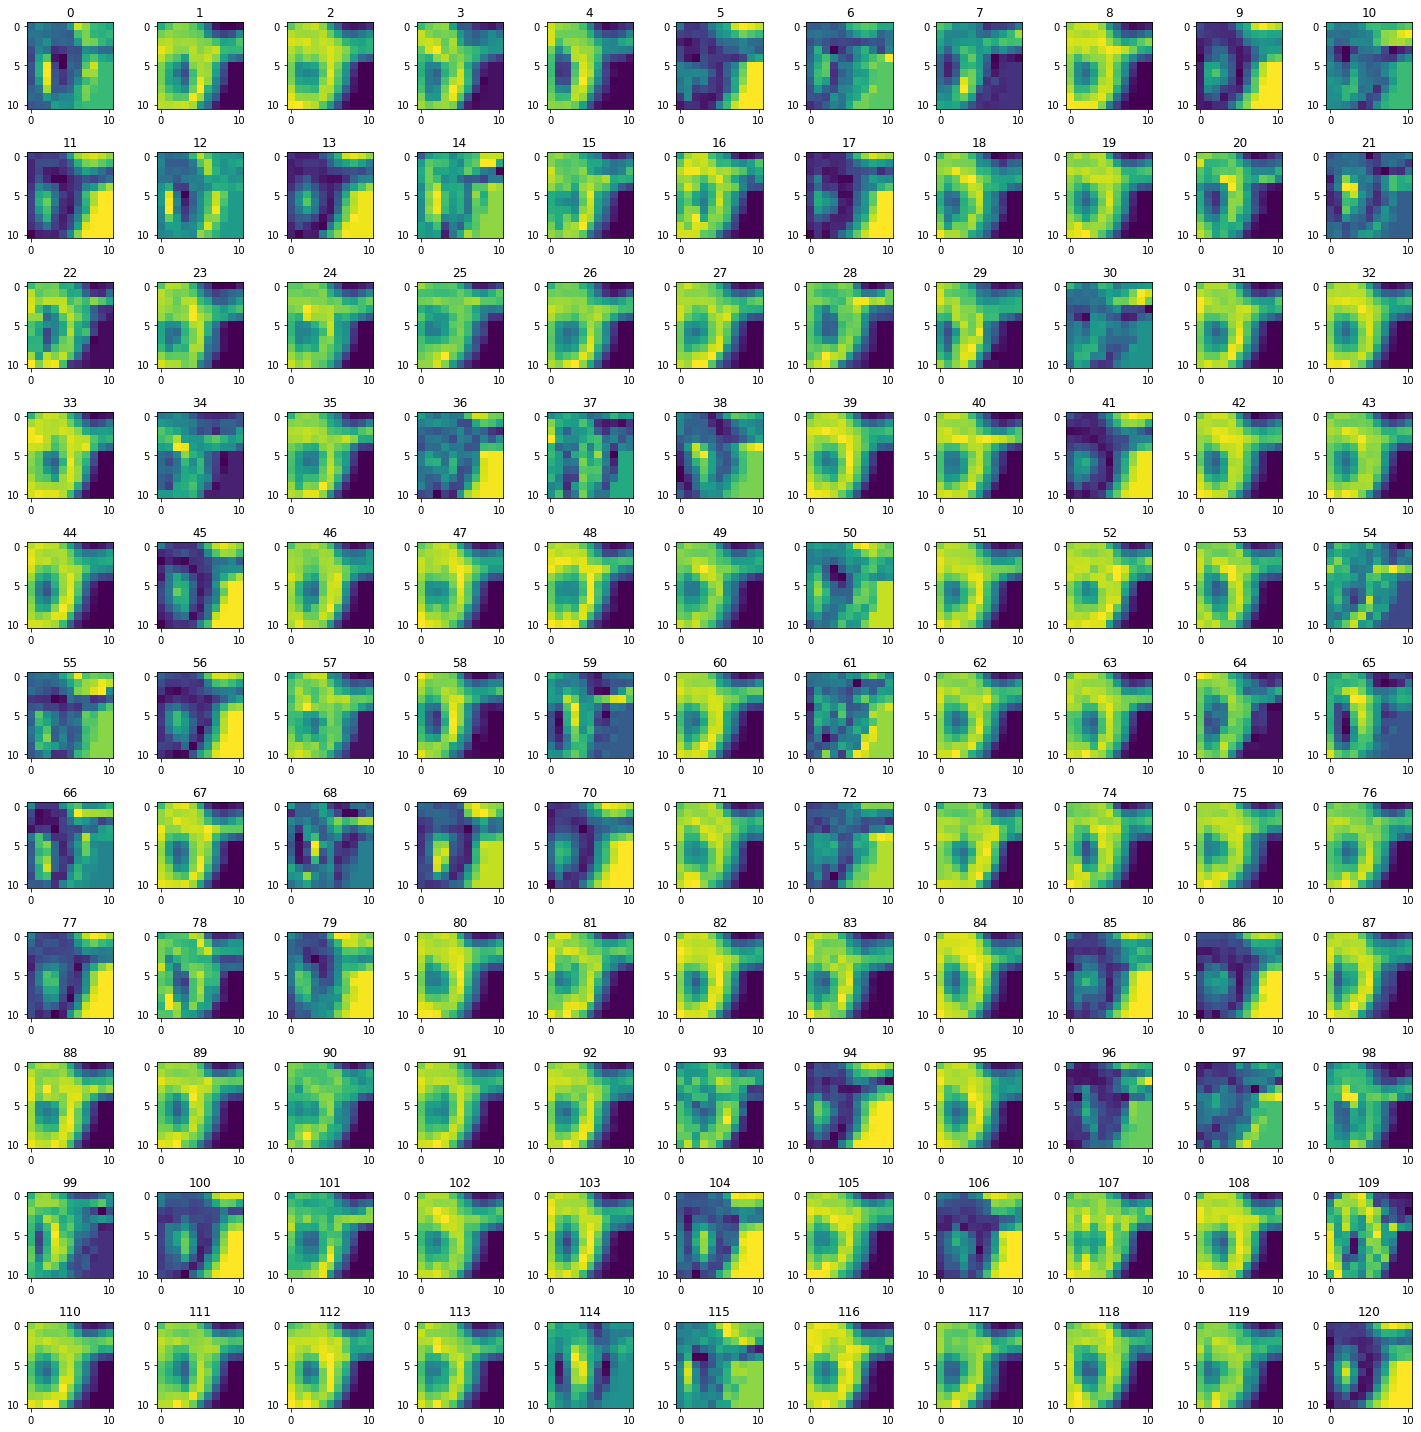

In [25]:
n = 11
fig, ax = plt.subplots(n, n, figsize=(20,20))
for ix, axis in enumerate(ax.flat):
    axis.imshow(second_intermediate_output[ix].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()

In [21]:
im.shape

torch.Size([1, 28, 28])

In [22]:
x, y = next(iter(trn_dl))
x2 = x[y==0]
len(x2)

32

In [23]:
x2 = x2.view(-1,1,28,28)

In [24]:
first_layer = nn.Sequential(*list(model.children())[:1])
first_layer_output = first_layer(x2).detach()

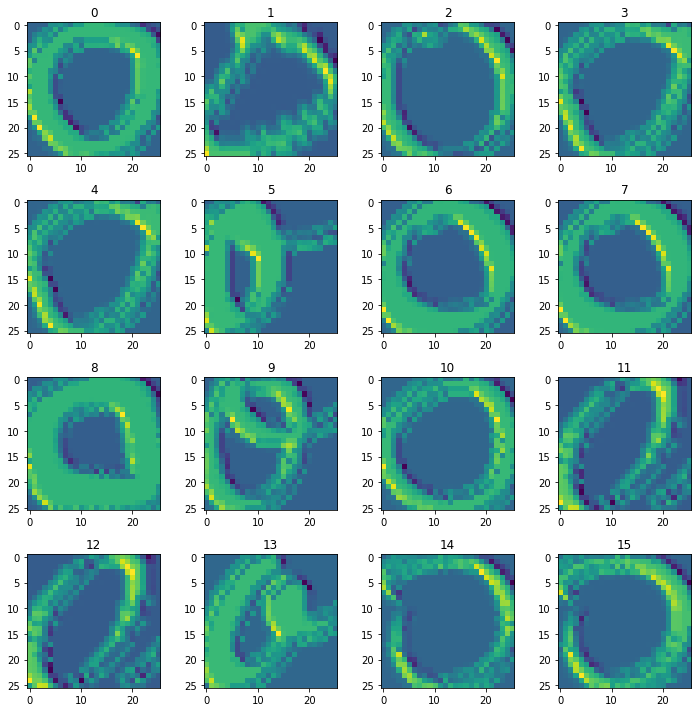

In [25]:
n = 4
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.imshow(first_layer_output[ix,4,:,:].cpu())
    axis.set_title(str(ix))
plt.tight_layout()
plt.show()